# # Projet : Classification du jeu de données HIGGS
---
**Objectifs :**
1. **Analyze the dataset** according to the description of dataset  
2. **Explain the selection of features** (note: there is no header in the CSV files)  
3. **Train the 3 models** (LogisticRegression, RandomForest, GBT) **with cross-validation and parameter tuning**  
4. **Compare the training time** with respect to the number of CPU cores used  
5. **Apply the trained models to the test dataset** and compare their performances by accuracy and ROC


## 1. Analyse du jeu de données
Dans cette première partie, on :
- Initialise une SparkSession simple (par défaut, local[*]).
- On lit les CSV (train/test) sans header.
- On affiche le schéma, quelques stats descriptives et des visualisations (histogrammes, corrélations).


In [11]:
#Import des bibliothèques nécessaires
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Démarrage d'une SparkSession pour l'analyse initiale
spark = SparkSession.builder \
    .appName("HIGGS_Analysis") \
    .master("local[*]") \
    .getOrCreate()

# Lecture du dataset d'entraînement et de test (sans header)
df_train_full = spark.read.csv(
    "/Users/tourgismacbook/Downloads/etc/Projet-Higgs/HIGGS-Train.csv",
    header=False,
    inferSchema=True
)
df_test_full = spark.read.csv(
    "/Users/tourgismacbook/Downloads/etc/Projet-Higgs/HIGGS-Test.csv",
    header=False,
    inferSchema=True
)

# Affichage rapide du schéma
print("=== Schéma du jeu de données (train) ===")
df_train_full.printSchema()

# Quelques lignes pour se faire une idée
print("\n=== Exemples de lignes du train ===")
df_train_full.show(5)

# Statistiques descriptives
print("\n=== Statistiques descriptives (df_train_full) ===")
summary_stats = df_train_full.describe().toPandas()
print(summary_stats)


=== Schéma du jeu de données (train) ===
root
 |-- _c0: double (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: double (nullable = true)
 |-- _c20: double (nullable = true)
 |-- _c21: double (nullable = true)
 |-- _c22: double (nullable = true)
 |-- _c23: double (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable 

  summary                 _c0                 _c1                   _c2  \
0   count             1000000             1000000               1000000   
1    mean            0.529673  0.9915919662907422  4.885219597013566E-4   
2  stddev  0.4991189860051024  0.5650989927094415     1.008275657787953   
3     min                 0.0  0.2746966481208801    -2.434976100921631   
4     max                 1.0    8.71178150177002    2.4348678588867188   

                     _c3                   _c4                    _c5  \
0                1000000               1000000                1000000   
1  -9.528433616999537E-4    0.9981498799093321  -5.725853022988021E-4   
2      1.005810231253231    0.5991514453524263      1.006808266200698   
3    -1.7425082921981812  6.259872461669147E-4    -1.7439435720443726   
4     1.7432359457015991      9.90092945098877     1.7432570457458496   

                   _c6                    _c7                   _c8  ...  \
0              1000000            

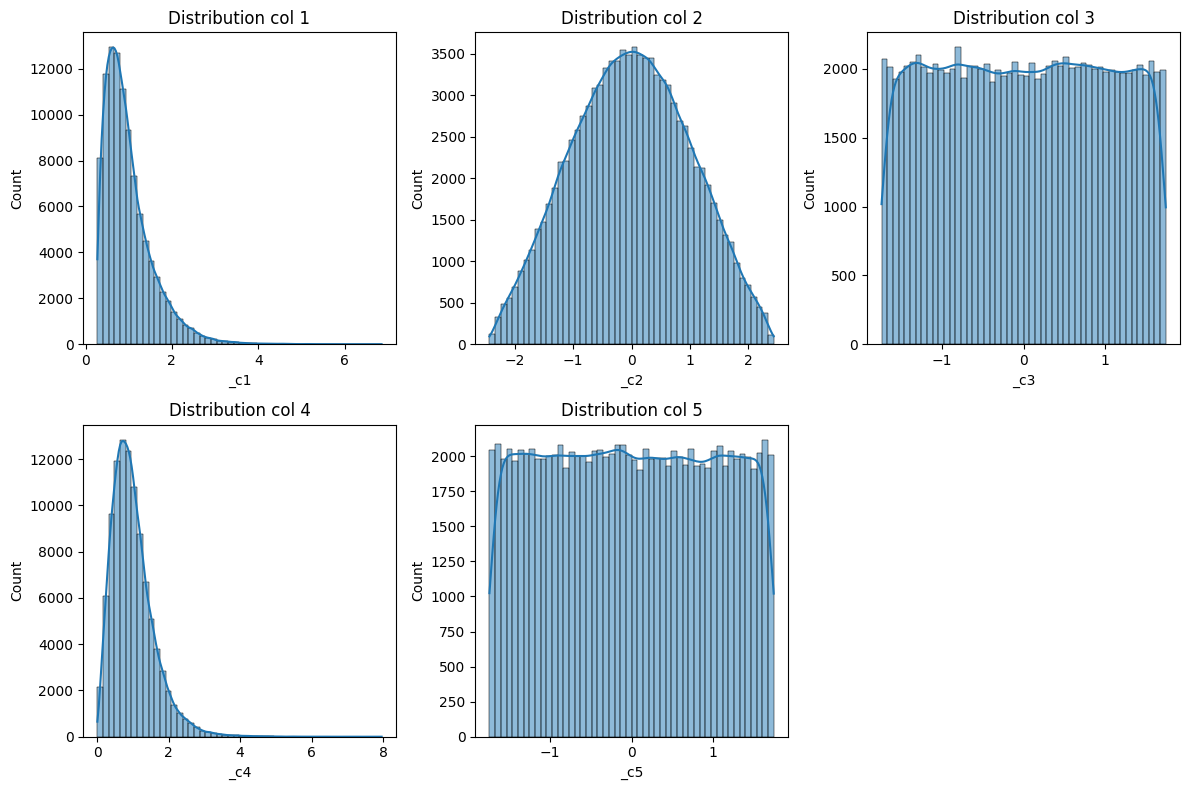


=== Corrélations avec la colonne 0 (label supposé) ===
   Feature  Correlation
0      _c1    -0.047785
1      _c2    -0.000113
2      _c3     0.001095
3      _c4    -0.099515
4      _c5    -0.001160
5      _c6     0.055723
6      _c7    -0.001360
7      _c8    -0.000361
8      _c9    -0.010886
9     _c10     0.021665
10    _c11     0.001252
11    _c12    -0.002438
12    _c13    -0.048911
13    _c14     0.014582
14    _c15     0.000230
15    _c16     0.000483
16    _c17    -0.023844
17    _c18     0.036789
18    _c19    -0.000713
19    _c20    -0.000306
20    _c21     0.014416
21    _c22     0.012307
22    _c23     0.025381
23    _c24     0.010434
24    _c25    -0.030940
25    _c26    -0.151233
26    _c27    -0.065186
27    _c28    -0.123071


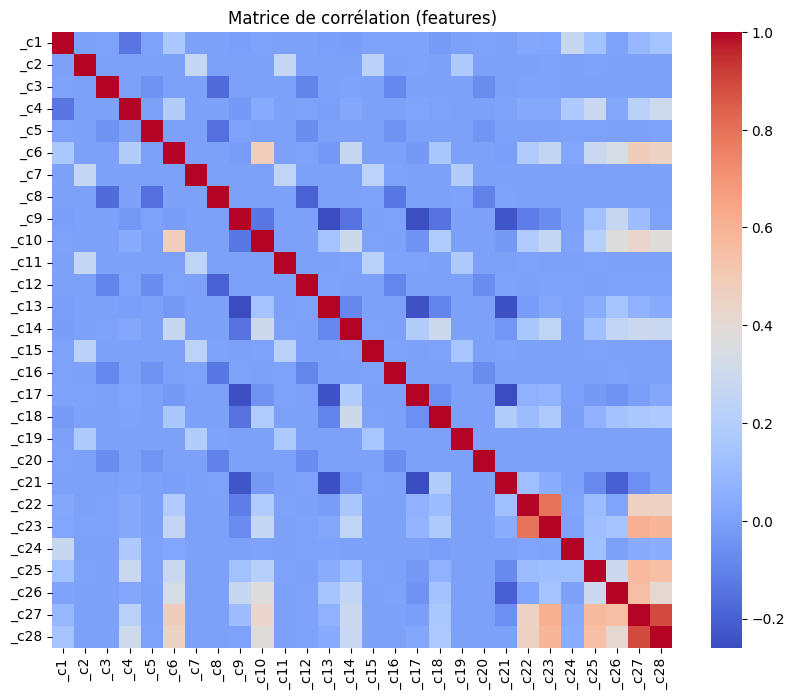

In [12]:
#Visualisations (histogrammes et corrélations)

# On va échantillonner une fraction (ex: 10%) pour éviter la surcharge
sample_df = df_train_full.sample(fraction=0.1, seed=42).toPandas()

# Histogrammes sur 5 colonnes (par exemple)
plt.figure(figsize=(12, 8))
for i in range(1, 6):
    plt.subplot(2, 3, i)
    sns.histplot(sample_df.iloc[:, i], bins=50, kde=True)
    plt.title(f"Distribution col {i}")
plt.tight_layout()
plt.show()

# Corrélation de la première colonne (label supposé) avec les autres
cols_train = df_train_full.columns
label_col = cols_train[0]      # _c0 (supposé label)
feature_cols = cols_train[1:]  # le reste des colonnes

correlations = []
for feat in feature_cols:
    corr_value = df_train_full.stat.corr(label_col, feat)
    correlations.append((feat, corr_value))

corr_df = pd.DataFrame(correlations, columns=["Feature", "Correlation"])
print("\n=== Corrélations avec la colonne 0 (label supposé) ===")
print(corr_df)

# Heatmap de la corrélation entre toutes les colonnes de features
df_corr_matrix = df_train_full.select(feature_cols).toPandas().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr_matrix, cmap="coolwarm")
plt.title("Matrice de corrélation (features)")
plt.show()


## 2. Sélection des features
- La première colonne (_c0) est considérée comme **label**.
- On retient seulement les 21 colonnes suivantes (1 à 21) en tant que **features**.
- On renomme donc la colonne 0 en "label" et les autres en "feature_1"... "feature_21".


In [3]:
# Sélection et renommage de 22 colonnes (label + 21 features)

# Dans la suite, on limitera nos DataFrames à ces 22 colonnes
df_train_limit = df_train_full.select(df_train_full.columns[:22])
df_test_limit  = df_test_full.select(df_test_full.columns[:22])

# Renommage : label + feature_1..feature_21
new_cols = ["label"] + [f"feature_{i}" for i in range(1, 22)]
df_train_limit = df_train_limit.toDF(*new_cols)
df_test_limit  = df_test_limit.toDF(*new_cols)

print("=== Exemples de lignes (renommées) ===")
df_train_limit.show(5)


=== Exemples de lignes (renommées) ===
+-----+------------------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+--------------------+-------------------+-----------------+-------------------+--------------------+--------------------+-----------------+
|label|         feature_1|          feature_2|          feature_3|         feature_4|          feature_5|         feature_6|           feature_7|          feature_8|         feature_9|        feature_10|         feature_11|         feature_12|        feature_13|        feature_14|          feature_15|         feature_16|       feature_17|         feature_18|          feature_19|          feature_20|       feature_21|
+-----+------------------+-------------------+-------------------+------------------+-------------------+--------------

## 3. Entraîner 3 modèles (LogisticRegression, RandomForest, GBT) avec Cross-Validation et tuning
## 4. Comparer le temps d'entraînement en fonction du nombre de cores CPU

Ici, on boucle sur `cores_list = [1, 2, 4]`. 
À chaque itération :
1. On redémarre une SparkSession avec le nombre de cœurs souhaité.
2. On refait le même pré-traitement (sélection + VectorAssembler).
3. On entraîne chaque modèle avec CrossValidator (3 plis).
4. On stocke l’AUC, l’Accuracy et le temps d’entraînement.


In [4]:
#Entraînement 3 modèles + CrossVal + Tuning + Mesure du temps

import time
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# On va faire un test avec 3 valeurs de cores
cores_list = [1, 2, 4]
cv_results = {}  # { (modelName, cores): {"AUC":..., "Accuracy":..., "TrainingTime":...}}

for cores in cores_list:
    print(f"\n=== [Point 4] Training with {cores} core(s) ===")
    
    # Redémarrer une SparkSession avec le nb de coeurs
    spark_cores = SparkSession.builder \
        .appName("HIGGSClassification") \
        .master(f"local[{cores}]") \
        .getOrCreate()
    
    # Re-lire et re-limiter les données
    df_train_tmp = spark_cores.read.csv(
        "/Users/tourgismacbook/Downloads/etc/Projet-Higgs/HIGGS-Train.csv",
        header=False, 
        inferSchema=True
    ).selectExpr(*[f"_c{i}" for i in range(22)])  # 22 premières colonnes
    
    df_test_tmp = spark_cores.read.csv(
        "/Users/tourgismacbook/Downloads/etc/Projet-Higgs/HIGGS-Test.csv",
        header=False, 
        inferSchema=True
    ).selectExpr(*[f"_c{i}" for i in range(22)])
    
    # Renommage
    new_cols = ["label"] + [f"feature_{i}" for i in range(1, 22)]
    df_train_tmp = df_train_tmp.toDF(*new_cols)
    df_test_tmp  = df_test_tmp.toDF(*new_cols)
    
    # VectorAssembler
    assembler = VectorAssembler(
        inputCols=[f"feature_{i}" for i in range(1, 22)],
        outputCol="features"
    )
    df_train_vec = assembler.transform(df_train_tmp).select("label", "features")
    df_test_vec  = assembler.transform(df_test_tmp).select("label", "features")
    
    # On définit 3 modèles
    models = {
        "LogisticRegression": LogisticRegression(featuresCol="features", labelCol="label"),
        "RandomForest": RandomForestClassifier(featuresCol="features", labelCol="label"),
        "GBT": GBTClassifier(featuresCol="features", labelCol="label")
    }
    
    # Évaluateurs
    roc_evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
    acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    
    # Entraînement pour chaque modèle
    for model_name, model in models.items():
        # ParamGrid (simple exemple)
        paramGrid = ParamGridBuilder()
        if model_name == "LogisticRegression":
            paramGrid = paramGrid.addGrid(model.regParam, [0.01, 0.1])
        elif model_name == "RandomForest":
            paramGrid = paramGrid.addGrid(model.numTrees, [10, 20])
        elif model_name == "GBT":
            paramGrid = paramGrid.addGrid(model.maxIter, [10, 20])
        paramGrid = paramGrid.build()
        
        crossval = CrossValidator(
            estimator=model,
            estimatorParamMaps=paramGrid,
            evaluator=roc_evaluator,  # On optimise sur l'AUC
            numFolds=3
        )
        
        start_time = time.time()
        cv_model = crossval.fit(df_train_vec)
        training_time = time.time() - start_time
        
        best_model = cv_model.bestModel
        predictions = best_model.transform(df_test_vec)
        
        # Calculer AUC + Accuracy
        auc = roc_evaluator.evaluate(predictions)
        accuracy = acc_evaluator.evaluate(predictions)
        
        print(f"[{model_name}, cores={cores}] AUC={auc:.4f} | Accuracy={accuracy:.4f} | TrainTime={training_time:.2f}s")
        
        cv_results[(model_name, cores)] = {
            "AUC": auc,
            "Accuracy": accuracy,
            "TrainingTime": training_time
        }
    
    # On stoppe la session pour passer au nombre de coeurs suivant
    spark_cores.stop()



=== [Point 4] Training with 1 core(s) ===


25/03/22 13:56:29 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/03/22 13:56:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/22 13:56:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


[LogisticRegression, cores=1] AUC=0.5959 | Accuracy=0.5663 | TrainTime=37.73s


[RandomForest, cores=1] AUC=0.6344 | Accuracy=0.5950 | TrainTime=47.36s


[GBT, cores=1] AUC=0.6745 | Accuracy=0.6244 | TrainTime=87.25s

=== [Point 4] Training with 2 core(s) ===


[LogisticRegression, cores=2] AUC=0.5958 | Accuracy=0.5663 | TrainTime=54.23s


[RandomForest, cores=2] AUC=0.6339 | Accuracy=0.5919 | TrainTime=80.97s


[GBT, cores=2] AUC=0.6742 | Accuracy=0.6239 | TrainTime=150.28s

=== [Point 4] Training with 4 core(s) ===


[LogisticRegression, cores=4] AUC=0.5958 | Accuracy=0.5663 | TrainTime=42.41s


[RandomForest, cores=4] AUC=0.6339 | Accuracy=0.5919 | TrainTime=66.54s


[GBT, cores=4] AUC=0.6742 | Accuracy=0.6239 | TrainTime=113.64s


## 5. Appliquer les modèles au jeu de test et comparer performances (AUC & Accuracy)

Nous avons déjà appliqué le *best_model* sur `df_test_vec` dans la boucle précédente, 
et nous avons stocké les performances dans `cv_results`.

Ici, on récapitule les résultats dans un dataframe Pandas, et on peut tracer des graphiques.


=== RÉSUMÉ DES RÉSULTATS ===
                Model  Cores       AUC  Accuracy  TrainingTime
0  LogisticRegression      1  0.595850  0.566302     37.730558
1        RandomForest      1  0.634410  0.595036     47.359470
2                 GBT      1  0.674500  0.624438     87.254137
3  LogisticRegression      2  0.595850  0.566302     54.234375
4        RandomForest      2  0.633946  0.591876     80.966666
5                 GBT      2  0.674245  0.623892    150.280998
6  LogisticRegression      4  0.595849  0.566302     42.412471
7        RandomForest      4  0.633949  0.591876     66.542011
8                 GBT      4  0.674246  0.623892    113.635633

=== Résultats triés par Modèle & Nombre de coeurs ===
                Model  Cores       AUC  Accuracy  TrainingTime
2                 GBT      1  0.674500  0.624438     87.254137
5                 GBT      2  0.674245  0.623892    150.280998
8                 GBT      4  0.674246  0.623892    113.635633
0  LogisticRegression      1  0.59

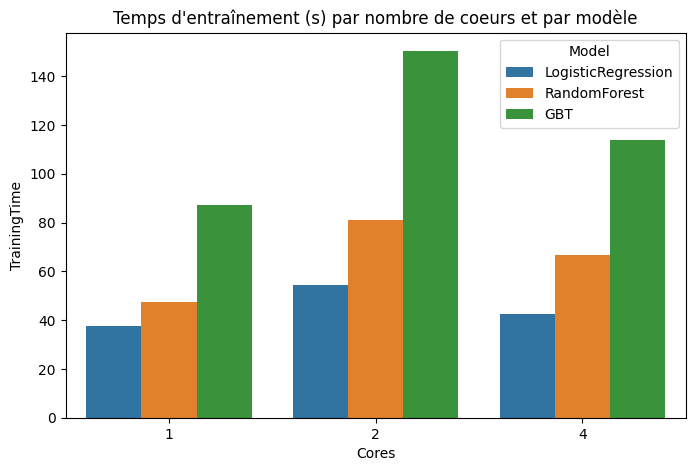

In [5]:
# Récapitulatif des résultats

import pandas as pd

# Convertir notre dict en liste
results_list = []
for (model_name, cores) in cv_results.keys():
    vals = cv_results[(model_name, cores)]
    results_list.append({
        "Model": model_name,
        "Cores": cores,
        "AUC": vals["AUC"],
        "Accuracy": vals["Accuracy"],
        "TrainingTime": vals["TrainingTime"]
    })

results_df = pd.DataFrame(results_list)
print("=== RÉSUMÉ DES RÉSULTATS ===")
print(results_df)

# Tri et affichage
results_df_sorted = results_df.sort_values(["Model", "Cores"])
print("\n=== Résultats triés par Modèle & Nombre de coeurs ===")
print(results_df_sorted)

# On peut aussi tracer un barplot du Temps d'entraînement par cores
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Cores", y="TrainingTime", hue="Model")
plt.title("Temps d'entraînement (s) par nombre de coeurs et par modèle")
plt.show()

# Stop final (optionnel si plus de calculs)
spark.stop()
